## Anomaly Detection of SPY (S&P500 ETF)

**Anomaly detection** (also known as outlier detection) is the identification of rare events or observations that deviate from the normal behavior of the other events or observations. To detect an anomaly, we first train an autoencoder on the time series. When we input a new time series, we reconstruct it using the autoencoder where if the reconstructed error is above a threshold we define, it is identified as an anomaly.

**Autoencoders** are considered unsupervised techniques in which input into a neural network is compressed and then reconstructed into an output with the same representation. It is an unsupervised technique because the input does not contain any labels to train on. However, autoencoders are trained using a self-supervised technique that looks to minimize the reconstruction loss. 

### LSTM AutoEncoder
For a given dataset of sequences, an LSTM Autoencoder contains a Encoder-Decoder architecture that reads an input sequences, encodes it, decodes it, and lastly reconstructs it where performance is evaluated based on the model's ability to reconstruct the input sequence. 

More on LSTM autoencoders:
https://machinelearningmastery.com/lstm-autoencoders/

### Task
* Can we use anomaly detection on the S&P500 etf to predict future behavior? 

#### Import Libraries

In [84]:
import datetime as dt
import pandas as pd
import pandas_datareader as web
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

#### Obtain Stock Data for SPY

In [85]:
ticker = 'SPY'
start = '2000-01-01'
end = pd.to_datetime('today')

df = web.DataReader(ticker, 'yahoo', start, end)
df = df[['Adj Close','Volume']]

#### Split into training/testing set
* First 95% of the sequence will be used as the training set

In [86]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5013, 2) (264, 2)


#### Standardize the data

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['Adj Close']])
train['Adj Close'] = scaler.transform(train[['Adj Close']])
test['Adj Close'] = scaler.transform(test[['Adj Close']])

<ipython-input-87-54e6d956b05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Adj Close'] = scaler.transform(train[['Adj Close']])
<ipython-input-87-54e6d956b05b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Adj Close'] = scaler.transform(test[['Adj Close']])


#### Choose time step (number of days our LSTM will have memory of)

In [88]:
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [89]:
TIME_STEPS = 30

X_train, y_train = create_dataset(
  train[['Adj Close']],
  train['Adj Close'],
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['Adj Close']],
  test['Adj Close'],
  TIME_STEPS
)
print(X_train.shape)

(4983, 30, 1)


#### Train LSTM

In [90]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(optimizer='adam', loss='mae')

In [91]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
141/141 [==============================] - 5s 35ms/step - loss: 0.1363 - val_loss: 0.1700
Epoch 2/100
141/141 [==============================] - 4s 29ms/step - loss: 0.1033 - val_loss: 0.1344
Epoch 3/100
141/141 [==============================] - 4s 30ms/step - loss: 0.0991 - val_loss: 0.1150
Epoch 4/100
141/141 [==============================] - 4s 29ms/step - loss: 0.0849 - val_loss: 0.0867
Epoch 5/100
141/141 [==============================] - 4s 29ms/step - loss: 0.0693 - val_loss: 0.0968
Epoch 6/100
141/141 [==============================] - 4s 30ms/step - loss: 0.0696 - val_loss: 0.0520
Epoch 7/100
141/141 [==============================] - 4s 31ms/step - loss: 0.0721 - val_loss: 0.1233
Epoch 8/100
141/141 [==============================] - 4s 29ms/step - loss: 0.0756 - val_loss: 0.0610
Epoch 9/100
141/141 [==============================] - 4s 30ms/step - loss: 0.0763 - val_loss: 0.1445
Epoch 10/100
141/141 [==============================] - 4s 29ms/step - loss: 0.089

141/141 [==============================] - 4s 31ms/step - loss: 0.0495 - val_loss: 0.1555
Epoch 81/100
141/141 [==============================] - 4s 31ms/step - loss: 0.0508 - val_loss: 0.1180
Epoch 82/100
141/141 [==============================] - 4s 31ms/step - loss: 0.0483 - val_loss: 0.0683
Epoch 83/100
141/141 [==============================] - 4s 31ms/step - loss: 0.0508 - val_loss: 0.1285
Epoch 84/100
141/141 [==============================] - 4s 31ms/step - loss: 0.0490 - val_loss: 0.0831
Epoch 85/100
141/141 [==============================] - 5s 34ms/step - loss: 0.0476 - val_loss: 0.1413
Epoch 86/100
141/141 [==============================] - 5s 33ms/step - loss: 0.0584 - val_loss: 0.0657
Epoch 87/100
141/141 [==============================] - 5s 33ms/step - loss: 0.0454 - val_loss: 0.0883
Epoch 88/100
141/141 [==============================] - 5s 35ms/step - loss: 0.0499 - val_loss: 0.0905
Epoch 89/100
141/141 [==============================] - 5s 33ms/step - loss: 0.0457 - 

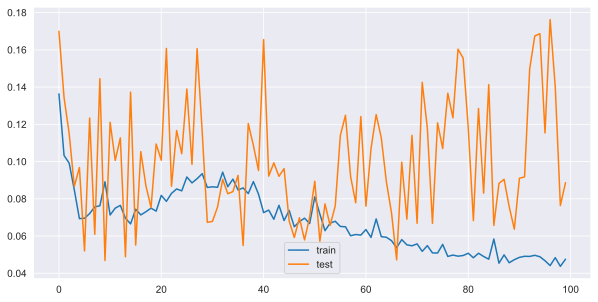

In [92]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [93]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [94]:
recon_error_threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {recon_error_threshold}')

Reconstruction error threshold: 0.3594122770939935


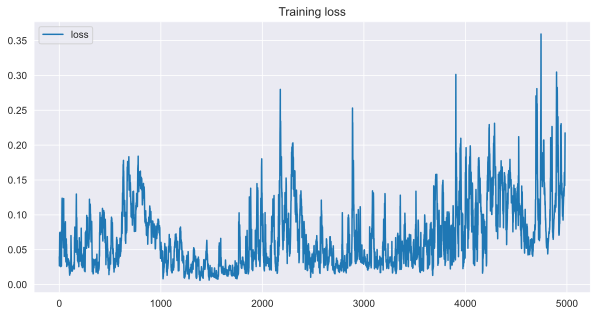

In [95]:
plt.figure(figsize=(10,5))
plt.title("Training loss")
plt.plot(train_mae_loss, label='loss')
plt.legend()
plt.show()

In [96]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [97]:
#THRESHOLD = 0.50
THRESHOLD = recon_error_threshold

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Adj Close'] = test[TIME_STEPS:]['Adj Close']

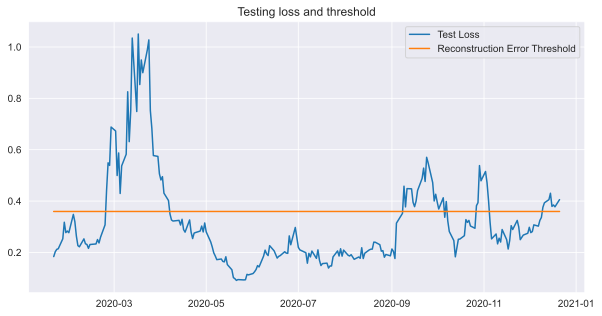

In [98]:
plt.figure(figsize=(10,5))
plt.title("Testing loss and threshold")
plt.plot(test_score_df.index, test_score_df.loss, label='Test Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Reconstruction Error Threshold')
plt.legend()
plt.show()

In [99]:
anomalies = test_score_df[test_score_df.anomaly == True]

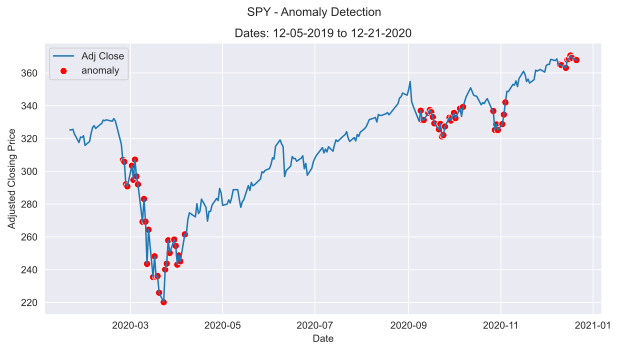

In [132]:
plt.figure(figsize=(10,5))
plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:]['Adj Close']), 
          label='Adj Close'
)

sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies['Adj Close']),
          color='red',
          s=52,
          label='anomaly'
)


plt.suptitle(f'{ticker} - Anomaly Detection')


test.index.map(lambda x: x.strftime('%m-%d-%Y'))[-1]
start = test.index.map(lambda x: x.strftime('%m-%d-%Y'))[0]
end = test.index.map(lambda x: x.strftime('%m-%d-%Y'))[-1]
plt.title(f"Dates: {start} to {end}")
plt.ylabel("Adjusted Closing Price")
plt.legend(loc='upper left')
plt.show()